# Full Resolution Code for Box, Oval, and Pelican

### Group 6 - Karthik Thiagarajan, Mason Shu, Siboney Cardoso, Agnitra Das

**Box image segmentation-**

Similarity Matrix:
[[  0. 100.   0. ...   0.   0.   0.]
 [100.   0. 100. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0. 100.]
 [100.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 161604 columns and 320800 nonzeros
Model fingerprint: 0x39f3c209
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 160082 columns
Presolve time: 0.03s
Presolved: 400 rows, 1522 columns, 3042 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statist

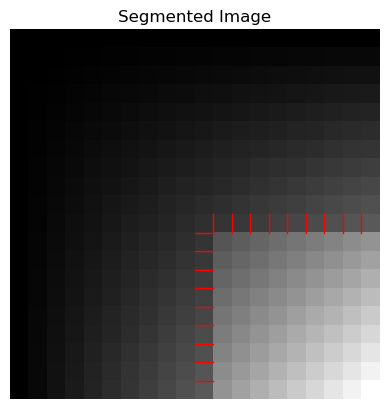

In [7]:
import numpy as np
import pandas as pd
from PIL import Image
import os

file_path = 'box.csv'  # Replace with your image file, e.g., 'image.jpg' or 'image.csv'

def load_image(file_path):
    _, ext = os.path.splitext(file_path)
    if ext.lower() == '.csv':
        image_data = pd.read_csv(file_path, header=None).values
    else:
        image = Image.open(file_path).convert('L')  # Convert to grayscale
        image_data = np.array(image)
    return image_data

# Load image data
image_data = load_image(file_path)
# Normalize pixel intensities between 0 and 1
image_data = image_data / image_data.max()
image_size = image_data.shape[0]

# Specifying the background and foreground pixel locations
foreground_pixel = np.unravel_index(np.argmax(image_data), image_data.shape)
background_pixel = np.unravel_index(np.argmin(image_data), image_data.shape)

# Create a 402x402 similarity matrix
similarity_matrix = np.zeros((image_size * image_size + 2, image_size * image_size + 2))

def calculate_similarity(Ii, Ij, sigma):
    return int(np.ceil(100 * np.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))))

sigma = 0.05

# Filling the similarity matrix for neighboring pixels
for row in range(image_size):
    for col in range(image_size):
        pixel_index = row * image_size + col
        current_intensity = image_data[row, col]

        # Specifying neighbors (diagonal neighbors not considered)
        neighbors = [(row - 1, col),(row + 1, col),(row, col - 1),(row, col + 1)]

        for neighbor in neighbors:
            n_row, n_col = neighbor
            if 0 <= n_row < image_size and 0 <= n_col < image_size:
                neighbor_index = n_row * image_size + n_col
                neighbor_intensity = image_data[n_row, n_col]
                
                # Calculating similarity and filling the matrix symmetrically
                similarity = calculate_similarity(current_intensity, neighbor_intensity, sigma)
                similarity_matrix[pixel_index, neighbor_index] = similarity
                similarity_matrix[neighbor_index, pixel_index] = similarity

# Mentioning source and sink indices
source_index = image_size * image_size
sink_index = source_index + 1

# Connecting the source node to the background pixel (one-way flow here)
background_index = background_pixel[0] * image_size + background_pixel[1]
similarity_matrix[source_index, background_index] = np.max(similarity_matrix)

# Connecting the foreground pixel to the sink node (one-way flow here again)
foreground_index = foreground_pixel[0] * image_size + foreground_pixel[1]
similarity_matrix[foreground_index, sink_index] = np.max(similarity_matrix)

print("Similarity Matrix:")
print(similarity_matrix)

import gurobipy as gp
model = gp.Model()

# Creating decision variables (the flow capacities of each link)
flow = model.addMVar((similarity_matrix.shape[0], similarity_matrix.shape[1]), 
                     lb=0, 
                     ub=similarity_matrix, 
                     name="flow")

# Objective func: Maximizing flow from source to background pixel
background_index = 0  # Background pixel index (change as needed)
model.setObjective(flow[source_index, background_index], gp.GRB.MAXIMIZE)

# flow in == flow out
model.addConstrs(
    (gp.quicksum(flow[j, i] for j in range(similarity_matrix.shape[1])) == gp.quicksum(flow[i, j] for j in range(similarity_matrix.shape[1]))
     for i in range(similarity_matrix.shape[0]) if i != source_index and i != sink_index))

model.optimize()

# Max flow obtained
if model.status == gp.GRB.OPTIMAL:
    optimal_value = model.objVal
    print("Optimal Objective Value (Max Flow):", optimal_value)
else:
    print("No optimal solution found.")

import matplotlib.pyplot as plt
flow_solution = flow.X

# Creating residual network
def create_residual_network(similarity_matrix, flow_solution):
    residual_network = similarity_matrix.copy()
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i][j] > 0:  # considering existing connections only
                residual_network[i][j] -= flow_solution[i][j]
    return residual_network

residual_network = create_residual_network(similarity_matrix, flow_solution)

# DFS to find accessible nodes
def dfs(residual_network, source, visited):
    visited.add(source)
    for j in range(residual_network.shape[0]):
        if residual_network[source][j] > 0 and j not in visited:
            dfs(residual_network, j, visited)

visited = set()
dfs(residual_network, image_size**2 , visited)

# Identifying cuts where visited nodes and inaccessible nodes have a non-zero flow
cuts = []
for i in visited:
    for j in range(similarity_matrix.shape[0]):
        if j not in visited and similarity_matrix[i][j] > 0:
            cuts.append((i, j))

# Drawing cuts on the original image
plt.imshow(image_data, cmap='gray')
for (i, j) in cuts:
    if i < image_size * image_size and j < image_size * image_size:
        row_i, col_i = divmod(i, image_size)
        row_j, col_j = divmod(j, image_size)
        if 0 <= row_i < image_size and 0 <= row_j < image_size:
            plt.plot([col_i-0.5, col_j-0.5], [row_i-0.5, row_j-0.5], 'r-', linewidth=1)

plt.title("Segmented Image")
plt.axis('off')
plt.show()

**Oval image segmentation-**

Similarity Matrix:
[[  0. 100.   0. ...   0.   0.   0.]
 [100.   0. 100. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [100.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 161604 columns and 320800 nonzeros
Model fingerprint: 0xc5d36cc0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 160082 columns
Presolve time: 0.09s
Presolved: 400 rows, 1522 columns, 3042 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statist

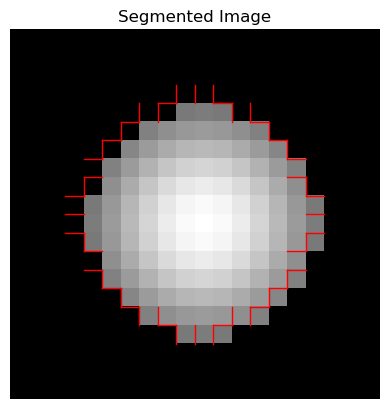

In [2]:
import numpy as np
import pandas as pd

# Loading pixel intensities from a CSV file
image_data = pd.read_csv('oval-1.csv', header=None).values
image_size = image_data.shape[0]  # For square images
sigma = 0.05

# Normalizing pixel intensities b/w 0 and 1
image_data = image_data/image_data.max()

# Specifying the background and foreground pixel locations
background_pixel = (0, 0)
foreground_pixel = (10,10)

# Create a 402x402 similarity matrix
similarity_matrix = np.zeros((image_size * image_size + 2, image_size * image_size + 2))

def calculate_similarity(Ii, Ij, sigma):
    return int(np.ceil(100 * np.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))))

# Filling the similarity matrix for neighboring pixels
for row in range(image_size):
    for col in range(image_size):
        pixel_index = row * image_size + col
        current_intensity = image_data[row, col]

        # Specifying neighbors (diagonal neighbors not considered)
        neighbors = [(row - 1, col),(row + 1, col),(row, col - 1),(row, col + 1)]

        for neighbor in neighbors:
            n_row, n_col = neighbor
            if 0 <= n_row < image_size and 0 <= n_col < image_size:
                neighbor_index = n_row * image_size + n_col
                neighbor_intensity = image_data[n_row, n_col]
                
                # Calculating similarity and filling the matrix symmetrically
                similarity = calculate_similarity(current_intensity, neighbor_intensity, sigma)
                similarity_matrix[pixel_index, neighbor_index] = similarity
                similarity_matrix[neighbor_index, pixel_index] = similarity

# Mentioning source and sink indices
source_index = image_size * image_size
sink_index = source_index + 1

# Connecting the source node to the background pixel (one-way flow here)
background_index = background_pixel[0] * image_size + background_pixel[1]
similarity_matrix[source_index, background_index] = np.max(similarity_matrix)

# Connecting the foreground pixel to the sink node (one-way flow here again)
foreground_index = foreground_pixel[0] * image_size + foreground_pixel[1]
similarity_matrix[foreground_index, sink_index] = np.max(similarity_matrix)

print("Similarity Matrix:")
print(similarity_matrix)

import gurobipy as gp
model = gp.Model()

# Creating decision variables (the flow capacities of each link)
flow = model.addMVar((similarity_matrix.shape[0], similarity_matrix.shape[1]), 
                     lb=0, 
                     ub=similarity_matrix, 
                     name="flow")

# Objective func: Maximizing flow from source to background pixel
background_index = 0  # Background pixel index (change as needed)
model.setObjective(flow[source_index, background_index], gp.GRB.MAXIMIZE)

# flow in == flow out
model.addConstrs(
    (gp.quicksum(flow[j, i] for j in range(similarity_matrix.shape[1])) == gp.quicksum(flow[i, j] for j in range(similarity_matrix.shape[1]))
     for i in range(similarity_matrix.shape[0]) if i != source_index and i != sink_index))

model.optimize()

# Max flow obtained
if model.status == gp.GRB.OPTIMAL:
    optimal_value = model.objVal
    print("Optimal Objective Value (Max Flow):", optimal_value)
else:
    print("No optimal solution found.")

import matplotlib.pyplot as plt
flow_solution = flow.X

# Creating residual network
def create_residual_network(similarity_matrix, flow_solution):
    residual_network = similarity_matrix.copy()
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i][j] > 0:  # considering existing connections only
                residual_network[i][j] -= flow_solution[i][j]
    return residual_network

residual_network = create_residual_network(similarity_matrix, flow_solution)

# DFS to find accessible nodes
def dfs(residual_network, source, visited):
    visited.add(source)
    for j in range(residual_network.shape[0]):
        if residual_network[source][j] > 0 and j not in visited:
            dfs(residual_network, j, visited)

visited = set()
dfs(residual_network, image_size**2 , visited)

# Identifying cuts where visited nodes and inaccessible nodes have a non-zero flow
cuts = []
for i in visited:
    for j in range(similarity_matrix.shape[0]):
        if j not in visited and similarity_matrix[i][j] > 0:
            cuts.append((i, j))

# Drawing cuts on the original image
plt.imshow(image_data, cmap='gray')
for (i, j) in cuts:
    if i < image_size * image_size and j < image_size * image_size:
        row_i, col_i = divmod(i, image_size)
        row_j, col_j = divmod(j, image_size)
        if 0 <= row_i < image_size and 0 <= row_j < image_size:
            plt.plot([col_i-0.5, col_j-0.5], [row_i-0.5, row_j-0.5], 'r-', linewidth=1)

plt.title("Segmented Image")
plt.axis('off')
plt.show()

**Triangle image segmentation-**

Similarity Matrix:
[[  0. 100.   0. ...   0.   0.   0.]
 [100.   0. 100. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [100.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 PRO 6860Z with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 161604 columns and 320800 nonzeros
Model fingerprint: 0x02de1441
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 160082 columns
Presolve time: 0.06s
Presolved: 400 rows, 1522 columns, 3042 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statist

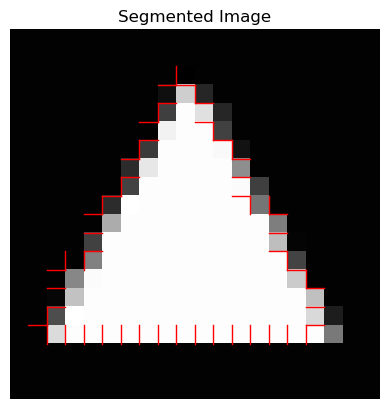

In [3]:
from PIL import Image
import numpy as np

# SKIP the next block if the image is in a csv file

# Loading the black and white image
image_path = 'triangle.png'
image = Image.open(image_path).convert('L')
# Converting the image to a NumPy array
pixel_intensity_array = np.array(image)

# START HERE if you have a csv file

# Exporting the pixel intensity array as a CSV file
csv_filename = 'triangle.csv'
np.savetxt(csv_filename, pixel_intensity_array, delimiter=',', fmt='%d')

import numpy as np
import pandas as pd

# Loading pixel intensities from a CSV file
image_data = pd.read_csv('triangle.csv', header=None).values
image_size = image_data.shape[0]  # For square images
sigma = 0.05

# Normalizing pixel intensities b/w 0 and 1
image_data = image_data/image_data.max()

# Specifying the background and foreground pixel locations
foreground_pixel = np.unravel_index(np.argmax(image_data), image_data.shape)
background_pixel = np.unravel_index(np.argmin(image_data), image_data.shape)

# Create a 402x402 similarity matrix
similarity_matrix = np.zeros((image_size * image_size + 2, image_size * image_size + 2))

def calculate_similarity(Ii, Ij, sigma):
    return int(np.ceil(100 * np.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))))

# Filling the similarity matrix for neighboring pixels
for row in range(image_size):
    for col in range(image_size):
        pixel_index = row * image_size + col
        current_intensity = image_data[row, col]

        # Specifying neighbors (diagonal neighbors not considered)
        neighbors = [(row - 1, col),(row + 1, col),(row, col - 1),(row, col + 1)]

        for neighbor in neighbors:
            n_row, n_col = neighbor
            if 0 <= n_row < image_size and 0 <= n_col < image_size:
                neighbor_index = n_row * image_size + n_col
                neighbor_intensity = image_data[n_row, n_col]
                
                # Calculating similarity and filling the matrix symmetrically
                similarity = calculate_similarity(current_intensity, neighbor_intensity, sigma)
                similarity_matrix[pixel_index, neighbor_index] = similarity
                similarity_matrix[neighbor_index, pixel_index] = similarity

# Mentioning source and sink indices
source_index = image_size * image_size
sink_index = source_index + 1

# Connecting the source node to the background pixel (one-way flow here)
background_index = background_pixel[0] * image_size + background_pixel[1]
similarity_matrix[source_index, background_index] = np.max(similarity_matrix)

# Connecting the foreground pixel to the sink node (one-way flow here again)
foreground_index = foreground_pixel[0] * image_size + foreground_pixel[1]
similarity_matrix[foreground_index, sink_index] = np.max(similarity_matrix)

print("Similarity Matrix:")
print(similarity_matrix)

import gurobipy as gp
model = gp.Model()

# Creating decision variables (the flow capacities of each link)
flow = model.addMVar((similarity_matrix.shape[0], similarity_matrix.shape[1]), 
                     lb=0, 
                     ub=similarity_matrix, 
                     name="flow")

# Objective func: Maximizing flow from source to background pixel
background_index = 0  # Background pixel index (change as needed)
model.setObjective(flow[source_index, background_index], gp.GRB.MAXIMIZE)

# flow in == flow out
model.addConstrs(
    (gp.quicksum(flow[j, i] for j in range(similarity_matrix.shape[1])) == gp.quicksum(
        flow[i, j] for j in range(similarity_matrix.shape[1]))
     for i in range(similarity_matrix.shape[0]) if i != source_index and i != sink_index))

model.optimize()

# Max flow obtained
if model.status == gp.GRB.OPTIMAL:
    optimal_value = model.objVal
    print("Optimal Objective Value (Max Flow):", optimal_value)
else:
    print("No optimal solution found.")

import matplotlib.pyplot as plt
flow_solution = flow.X

# Creating residual network
def create_residual_network(similarity_matrix, flow_solution):
    residual_network = similarity_matrix.copy()
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i][j] > 0:  # considering existing connections only
                residual_network[i][j] -= flow_solution[i][j]
    return residual_network

residual_network = create_residual_network(similarity_matrix, flow_solution)

# DFS to find accessible nodes
def dfs(residual_network, source, visited):
    visited.add(source)
    for j in range(residual_network.shape[0]):
        if residual_network[source][j] > 0 and j not in visited:
            dfs(residual_network, j, visited)

visited = set()
dfs(residual_network, image_size**2 , visited)

# Identifying cuts where visited nodes and inaccessible nodes have a non-zero flow
cuts = []
for i in visited:
    for j in range(similarity_matrix.shape[0]):
        if j not in visited and similarity_matrix[i][j] > 0:
            cuts.append((i, j))

# Drawing cuts on the original image
plt.imshow(image_data, cmap='gray')
for (i, j) in cuts:
    if i < image_size * image_size and j < image_size * image_size:
        row_i, col_i = divmod(i, image_size)
        row_j, col_j = divmod(j, image_size)
        if 0 <= row_i < image_size and 0 <= row_j < image_size:
            plt.plot([col_i-0.5, col_j-0.5], [row_i-0.5, row_j-0.5], 'r-', linewidth=1)

plt.title("Segmented Image")
plt.axis('off')
plt.show()

**Attempt at segmenting the Swan image (used help from ChatGPT)-**

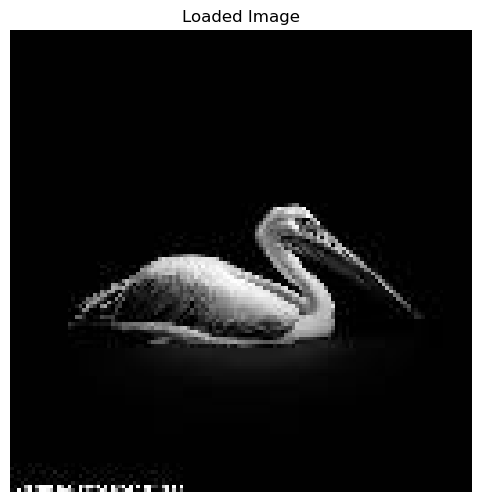

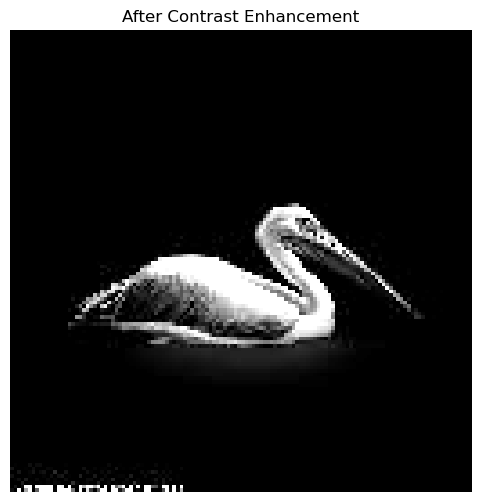

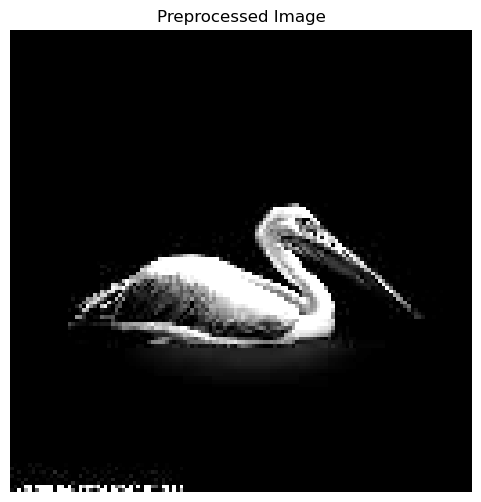

Image shape: (128, 128)
Image max intensity: 1.0
Image min intensity: 0.0
Computed Otsu threshold: 0.412109375


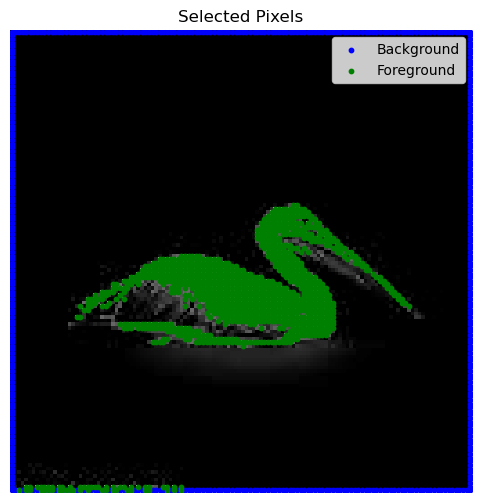

Computed sigma: 0.10839624114079746
Maximum flow value: 3876.0
Number of cuts found: 527
Total cut capacity: 4331.0


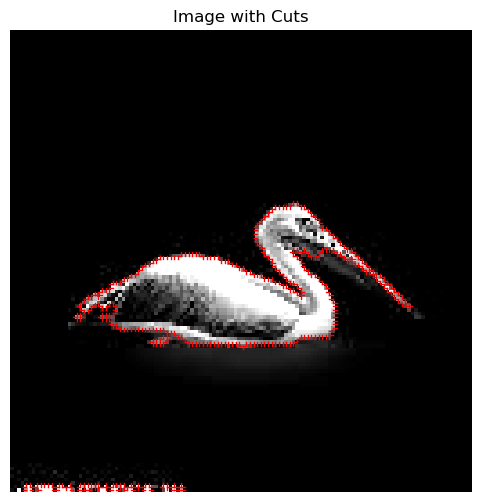

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import gurobipy as gp
from gurobipy import GRB
from skimage.filters import threshold_otsu
import pandas as pd
import os

# Loaded and preprocessed the file (either JPEG or CSV)
file_path = 'pelican.jpg'  # Adjust the file name based on the image to be processed (can be .jpg or .csv)

def load_file(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == '.jpg':
        img = Image.open(file_path).convert('L')  # Converted JPEG to grayscale
        return np.array(img) / 255.0  # Normalize to [0, 1]

    elif file_extension == '.csv':
        df = pd.read_csv(file_path, header=None)  # Loaded CSV as DataFrame
        return df.values / 255.0  # Normalized to [0, 1]

    else:
        raise ValueError("Unsupported file format. Use .jpg or .csv.")

# Loaded the data based on the file type
image = load_file(file_path)

# Displayed the original image/CSV content
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Loaded Image')
plt.axis('off')
plt.show()

# Enhanced Contrast (only for images, not for CSVs)
if file_path.endswith('.jpg'):
    img = Image.fromarray((image * 255).astype(np.uint8))  # Converted back to Image for enhancement
    enhancer = ImageEnhance.Contrast(img)
    img_enhanced = enhancer.enhance(1.5)  # Adjusted enhancement factor
    image = np.array(img_enhanced) / 255.0  # Normalized after enhancement

    # Displayed after contrast enhancement
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray', origin='upper')
    plt.title('After Contrast Enhancement')
    plt.axis('off')
    plt.show()

# Preprocessed the image/CSV
num_rows, num_cols = image.shape

# Displayed the preprocessed image/CSV data
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Preprocessed Image')
plt.axis('off')
plt.show()

# Check image statistics
print(f"Image shape: {image.shape}")
print(f"Image max intensity: {image.max()}")
print(f"Image min intensity: {image.min()}")

# Specified background and foreground pixels
# Background pixels: All border pixels
border_pixels = []
for row in range(num_rows):
    for col in range(num_cols):
        if row == 0 or row == num_rows - 1 or col == 0 or col == num_cols - 1:
            border_pixels.append((row, col))

# Computed Otsu's threshold for foreground selection
threshold = threshold_otsu(image)
print(f"Computed Otsu threshold: {threshold}")

# Foreground pixels: Pixels with intensity above the threshold
foreground_pixels = [
    (row, col) for row in range(num_rows)
    for col in range(num_cols)
    if image[row, col] > threshold
]

# Plotted the selected background and foreground pixels
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray', origin='upper')
plt.scatter(
    [col for row, col in border_pixels],
    [row for row, col in border_pixels],
    color='blue',
    s=10,
    label='Background'
)
plt.scatter(
    [col for row, col in foreground_pixels],
    [row for row, col in foreground_pixels],
    color='green',
    s=10,
    label='Foreground'
)
plt.title('Selected Pixels')
plt.legend()
plt.axis('off')
plt.show()

# Constructed the flow network
num_pixels = num_rows * num_cols
total_nodes = num_pixels + 2   # Including source and sink
source = num_pixels            # Source node index
sink = num_pixels + 1          # Sink node index

# Function to map 2D pixel coordinates to 1D index
def pixel_index(row, col):
    return row * num_cols + col

# Computed intensity differences between neighboring pixels
intensity_diffs = []
for row in range(num_rows):
    for col in range(num_cols):
        Ii = image[row, col]
        neighbors = []
        if row > 0:
            neighbors.append(image[row - 1, col])
        if row < num_rows - 1:
            neighbors.append(image[row + 1, col])
        if col > 0:
            neighbors.append(image[row, col - 1])
        if col < num_cols - 1:
            neighbors.append(image[row, col + 1])
        for Ij in neighbors:
            intensity_diffs.append(abs(Ii - Ij))

# Computed sigma as the standard deviation of intensity differences
sigma = np.std(intensity_diffs)
print(f"Computed sigma: {sigma}")

# Initialized the network capacity matrix
network = np.zeros((total_nodes, total_nodes), dtype=float)

# Computed similarities and fill the network matrix
max_similarity = 0
for row in range(num_rows):
    for col in range(num_cols):
        idx = pixel_index(row, col)
        Ii = image[row, col]
        neighbors = []
        if row > 0:
            neighbors.append((row - 1, col))
        if row < num_rows - 1:
            neighbors.append((row + 1, col))
        if col > 0:
            neighbors.append((row, col - 1))
        if col < num_cols - 1:
            neighbors.append((row, col + 1))
        for n_row, n_col in neighbors:
            n_idx = pixel_index(n_row, n_col)
            Ij = image[n_row, n_col]
            intensity_diff = Ii - Ij
            similarity = np.ceil(100 * np.exp(- (intensity_diff) ** 2 / (2 * sigma ** 2)))
            similarity = float(similarity)
            network[idx, n_idx] = similarity
            network[n_idx, idx] = similarity  # Undirected network
            if similarity > max_similarity:
                max_similarity = similarity

# **Swapped the source and sink connections**
# Connected all foreground pixels to the source
for row, col in foreground_pixels:
    idx = pixel_index(row, col)
    network[source, idx] = max_similarity

# Connected all border pixels to the sink
for row, col in border_pixels:
    idx = pixel_index(row, col)
    network[idx, sink] = max_similarity

# Formulated and solve the Max Flow problem with Gurobi
model = gp.Model("Image_Segmentation")
model.Params.OutputFlag = 0  # Suppress solver output
# Identified all edges with positive capacity
edges = np.argwhere(network > 0)
num_edges = edges.shape[0]
# Added flow variables for each edge
flows = model.addVars(num_edges, lb=0, ub=network[edges[:,0], edges[:,1]], name='flow')
# Set objective: maximize flow from source to sink
source_edges = [i for i, (u, v) in enumerate(edges) if u == source]
model.setObjective(gp.quicksum(flows[i] for i in source_edges), GRB.MAXIMIZE)
# Added flow conservation constraints for each node except source and sink
for node in range(total_nodes):
    if node == source or node == sink:
        continue
    in_edges = [i for i, (u, v) in enumerate(edges) if v == node]
    out_edges = [i for i, (u, v) in enumerate(edges) if u == node]
    model.addConstr(
        gp.quicksum(flows[i] for i in in_edges) == gp.quicksum(flows[i] for i in out_edges),
        name=f'flow_conservation_node_{node}'
    )
# Optimized the model
model.optimize()
# Identified and visualize the cuts
if model.status == GRB.OPTIMAL:
    print(f"Maximum flow value: {model.objVal}")
    # Extract flow values
    flow_values = model.getAttr('X', flows)
    # Built residual network
    residual_network = np.copy(network)
    for i in range(num_edges):
        u, v = edges[i]
        flow = flow_values[i]
        residual_network[u, v] -= flow
    # Performed DFS to find reachable nodes from source in residual network
    visited = [False] * total_nodes
    def dfs(u):
        visited[u] = True
        neighbors = np.where(residual_network[u, :] > 1e-6)[0]
        for v in neighbors:
            if not visited[v]:
                dfs(v)
    dfs(source)
    # Identified cut edges: edges from visited to unvisited nodes
    cuts = []
    for i in range(num_edges):
        u, v = edges[i]
        if visited[u] and not visited[v]:
            cuts.append((u, v))
    print(f"Number of cuts found: {len(cuts)}")
    # Summed the capacities of the cuts
    cut_capacity = sum(network[u, v] for u, v in cuts)
    print(f"Total cut capacity: {cut_capacity}")
    if abs(model.objVal - cut_capacity) < 1e-6:
        print("Max flow equals min cut capacity (verified).")
# Plotted the original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Image with Cuts')
plt.axis('off')
# Overlayed the cuts with red lines
for u, v in cuts:
    if u >= num_pixels or v >= num_pixels:
        continue
    u_row, u_col = divmod(u, num_cols)
    v_row, v_col = divmod(v, num_cols)
    plt.plot([u_col, v_col], [u_row, v_row], color='red', linewidth=1)
plt.show()